In [ ]:
## STEPS
## Speech Recognition 

In [5]:
# 1
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import os
import glob
import IPython.display as ipd
from google.colab import files
import json
from sklearn.utils import shuffle
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd

In [6]:
# 2
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!mkdir SAVE_MODEL

In [8]:
#3
cd /content/gdrive/MyDrive/Saved_Model

/content/gdrive/MyDrive/Saved_Model


In [16]:
data_path = "/content/gdrive/MyDrive/file rekaman 30x pengulangan"

In [17]:
test_files = glob.glob(os.path.join(data_path + '/*/', '*.wav'))
test_files.sort()

In [18]:
test_files[0]


'/content/gdrive/MyDrive/file rekaman 30x pengulangan/10sepeda/1 (1).wav'

In [19]:
test_file = test_files[0]

In [20]:
ipd.Audio(test_file)

In [21]:
#MFCC manually
#Get AUDIO
sample_rate, audio = wavfile.read(test_file)
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Audio duration: 1.6011041666666668s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

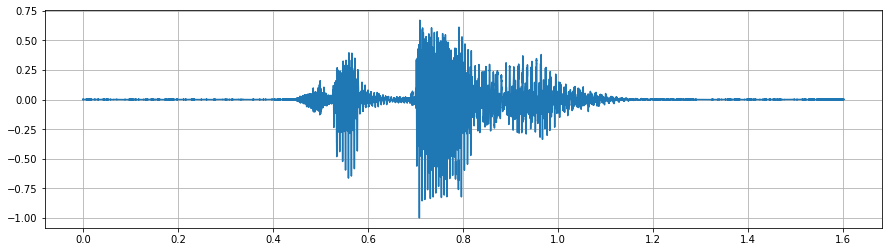

In [ ]:
# Plot Audio
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [ ]:
#AUDIO FRAMMING for Apply Short Fourier Transform
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [ ]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (107, 2048)


In [ ]:
FFT_size=2048
hop_size=10
sample_rate=44100

np.pad(audio, int(FFT_size / 2), mode='reflect').shape

(78901,)

In [ ]:
print("All frame")
audio_framed[0:]

All frame


array([[ 0.        ,  0.00016383, -0.00032765, ...,  0.00016383,
        -0.00032765,  0.00016383],
       [ 0.00032765, -0.00016383,  0.        , ..., -0.00032765,
         0.00032765, -0.00016383],
       [-0.00016383,  0.00016383, -0.00016383, ...,  0.00016383,
         0.        , -0.00032765],
       ...,
       [-0.00016383,  0.00016383,  0.        , ...,  0.00016383,
         0.00131062,  0.00016383],
       [-0.00081913, -0.00016383, -0.00131062, ..., -0.00049148,
        -0.00049148, -0.00049148],
       [ 0.00163827,  0.00081913,  0.00196592, ...,  0.00049148,
         0.        ,  0.        ]])

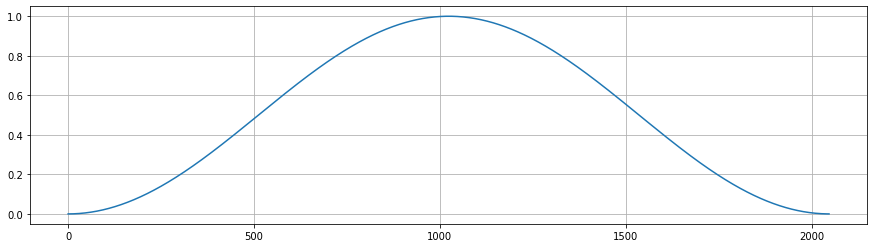

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

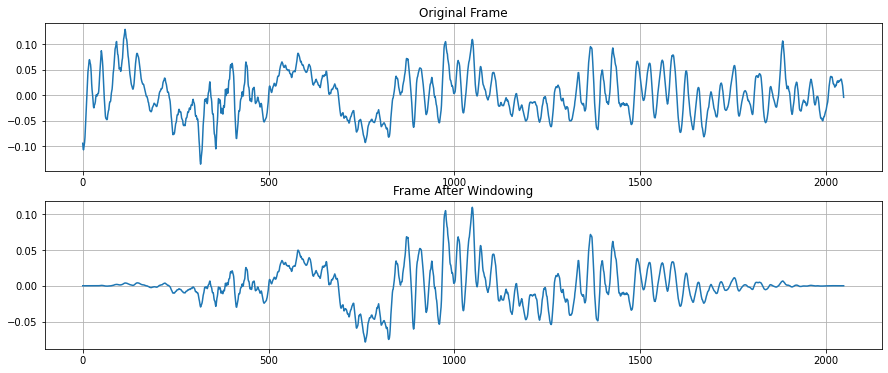

In [ ]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [ ]:
#FFT signal 
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(107, 1025)


In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [ ]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [ ]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [ ]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

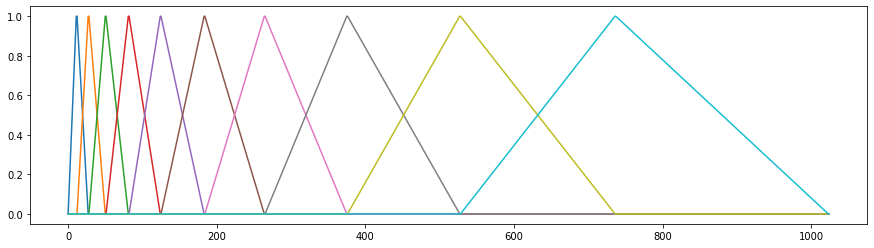

In [ ]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

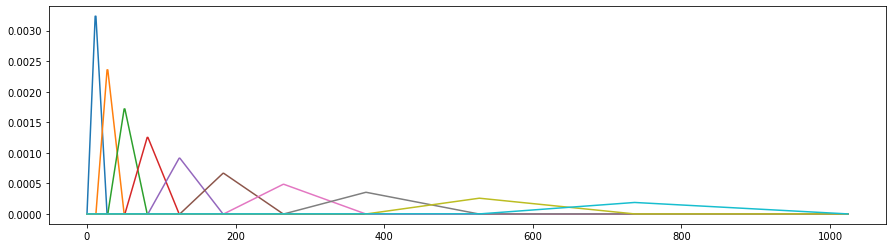

In [ ]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 107)

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [ ]:
dct_filter_num = 13

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(13, 107)

In [ ]:
cepstral_coefficents[:, 0]

array([-2.35634476e+02, -2.50045192e+01,  1.68138785e+01, -4.84165436e+00,
       -1.06676504e+00, -1.32349194e+00,  5.03235902e+00, -5.29340157e+00,
        5.60652003e-01,  6.11266136e-01,  2.82494451e-13, -6.11266136e-01,
       -5.60652003e-01])

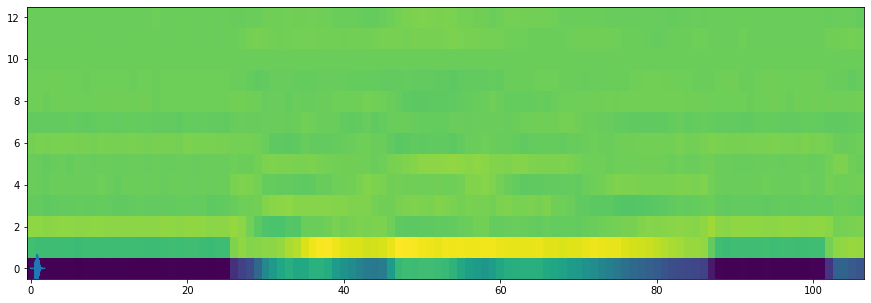

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [ ]:
#MFCC with librosa
signal_test, sample_rate = librosa.load(test_files[0])
num_mfcc=13
n_fft = 2048
hop_length = 512
MFCCs_test = librosa.feature.mfcc(signal_test, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,hop_length=hop_length)

In [ ]:
## Array to append by data
MFCCs = []
labels = []
mapping = []
files = []
SAMPLES_TO_CONSIDER = 22050


In [ ]:
##callback 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print("\nAkurasi di atas 99%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
SAMPLES_TO_CONSIDER = 22050 # for 1 sec
def extract_mfccs(data_path, num_mfcc=13, n_fft=2048, hop_length=512):


    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

       
        if dirpath is not data_path:

            # save label for every sub-folder name in the mapping
            label = dirpath.split("/")[-1]
            mapping.append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file 
                signal, sample_rate = librosa.load(file_path)

                # drop audio if more than 1 s
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # Consistensy signal length
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCss = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)

                    # store data 
                    MFCCs.append(MFCCss.T.tolist())
                    labels.append(i-1)
                    files.append(file_path)
                    print("{}: {}".format(file_path, i-1))

In [ ]:
extract_mfccs(data_path)


Processing: '4buka'
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/Salinan buka3.wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/Salinan buka2.wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (1).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (2).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (3).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (4).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (5).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (6).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (7).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (8).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (9).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (10).wav: 0
/content/gdrive/MyDrive/file rekaman 30x pengulangan/4buka/1 (11).wav: 0
/content/gdrive/MyDrive/f

In [ ]:
cd /content/gdrive/MyDrive/Saved_Model

/content/gdrive/MyDrive/Saved_Model


In [ ]:
#Save JSON MFCC
save_mfcc = {"MFCCs": MFCCs, "labels": labels, "mapping": mapping, "files": files}
with open('text.json_testFP1_1', 'w+') as f:
  json.dump(save_mfcc, f)

In [ ]:
#LOAD JSON MFCC
json.load,
with open('/content/gdrive/MyDrive/Saved_Model/text.json_testFP1_1', 'r') as f:
 data = json.load(f)

MFCCs = data["MFCCs"]
labels = data["labels"]
mapping = data["mapping"]
files = data["files"]

In [ ]:
#declare random seed
tf.random.set_seed(42)

In [ ]:
#HYPER PARAMETER
EPOCHS = 200
BATCH_SIZE = 32


In [ ]:
#append MFccs and labels to x and y
X = np.array(MFCCs)
y = np.array(labels)

In [ ]:
#shuffle for better training
X, y = shuffle(X, y)

In [ ]:
X.shape

(1394, 44, 13)

In [ ]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
#split train Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
#Reshape CNN CNN need to be 4 dim
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [ ]:
X_train.min(),X_train.max()
#need normalization

(-881.6046752929688, 271.52374267578125)

In [ ]:
X_train.shape

(121, 44, 13, 1)

In [ ]:
X_test.shape

(39, 44, 13, 1)

In [ ]:
#Model CNN
def model_CNN():
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1),
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

(102, 44, 13, 1)

In [ ]:
model = model_CNN()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 2, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 1, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 1, 32)         0

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE,validation_data=(X_validation, y_validation),callbacks=[callbacks])

Epoch 1/500
28/28 [==============================] - 2s 44ms/step - loss: 4.6841 - accuracy: 0.1682 - val_loss: 1.8721 - val_accuracy: 0.3946
Epoch 2/500
28/28 [==============================] - 1s 36ms/step - loss: 1.4212 - accuracy: 0.5202 - val_loss: 0.9083 - val_accuracy: 0.7444
Epoch 3/500
28/28 [==============================] - 1s 36ms/step - loss: 0.7570 - accuracy: 0.7691 - val_loss: 0.5395 - val_accuracy: 0.8565
Epoch 4/500
28/28 [==============================] - 1s 37ms/step - loss: 0.4240 - accuracy: 0.8969 - val_loss: 0.3787 - val_accuracy: 0.9148
Epoch 5/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3046 - accuracy: 0.9395 - val_loss: 0.2691 - val_accuracy: 0.9507
Epoch 6/500
28/28 [==============================] - 1s 37ms/step - loss: 0.2269 - accuracy: 0.9608 - val_loss: 0.2509 - val_accuracy: 0.9507
Epoch 7/500
28/28 [==============================] - 1s 39ms/step - loss: 0.1751 - accuracy: 0.9731 - val_loss: 0.2325 - val_accuracy: 0.9372
Epoch 

In [ ]:
cd /content/gdrive/MyDrive/Saved_Model

/content/gdrive/MyDrive/Saved_Model


In [ ]:
model.predict(X)

array([[9.9877137e-01, 5.5732817e-04, 9.2929918e-07, ..., 8.7289340e-09,
        4.1689131e-07, 1.1637263e-08],
       [4.3193935e-04, 8.0764416e-04, 1.0871612e-02, ..., 5.4036229e-07,
        2.1248596e-05, 5.4639123e-08],
       [3.5165045e-05, 5.8980411e-05, 9.8640788e-01, ..., 1.7175756e-07,
        1.0697858e-05, 3.8166760e-08],
       ...,
       [1.2911762e-04, 3.7421614e-02, 8.8580083e-03, ..., 1.8128874e-05,
        1.9916601e-05, 4.4017412e-05],
       [1.6713368e-04, 8.6564803e-01, 2.0257701e-05, ..., 1.8811490e-05,
        9.9948620e-06, 1.0296714e-05],
       [9.5802279e-06, 2.8049874e-03, 9.8697805e-01, ..., 5.3383365e-06,
        3.1645686e-05, 6.5441816e-07]], dtype=float32)

In [ ]:

#Save model to file
model.save("model_test_FP_FIX_2.h5")

In [ ]:
#load Model
tf.keras.models.load_model(SAVED_MODEL_PATH)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 0s 16ms/step - loss: 0.2358 - accuracy: 0.9570
test loss, test acc: [0.23579730093479156, 0.9569892287254333]


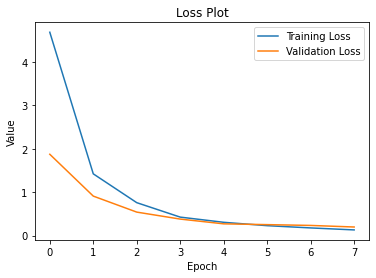

In [ ]:
from matplotlib import pyplot as plt
#loss train & validation plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

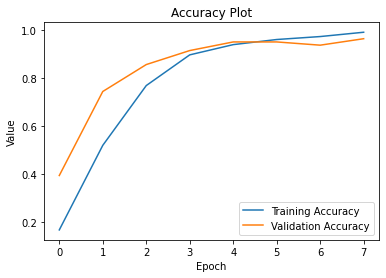

In [ ]:
#accuracy train & validation plotting
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#4
SAVED_MODEL_PATH = "model_test_FP_FIX_2.h5"

In [7]:
#3
cd /content/gdrive/MyDrive/Saved_Model

NameError: ignored

In [ ]:
#5
SAMPLES_TO_CONSIDER = 22050
class _Keyword_Spotting_Service:

      model = None
      _mapping = ["buka","kalian","tutup","pulang","pergi","saya","main","boia","sepeda","lapangan"]
      _instance = None
      def predict(self, file_path):

        # extract MFCC
        MFCCs = self.preprocess(file_path)
        #MFCCs = self.preprocess(uploaded)
        
        MFCCs = MFCCs[np.newaxis,..., np.newaxis]
        #MFCCs = MFCCs[MFCCs.shape[0], MFCCs.shape[1],1]
        # get the predicted label
        predictions = self.model.predict(MFCCs)
        predicted_index = np.argmax(predictions)
        predicted_keyword = self._mapping[predicted_index]
        return predicted_keyword
      def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512):
        #Extract MFCCs from audio file.

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= SAMPLES_TO_CONSIDER:#SAMPLES_TO_CONSIDER:
            #consistency of the length of the signal
            signal = signal[:SAMPLES_TO_CONSIDER] #signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs from audio file
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
        return MFCCs.T


In [ ]:
 #6
 def Keyword_Spotting_Service():
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance 

In [ ]:
#Uploaded test wav file (kalau make data dari luar drive)
from google.colab import files

uploaded = files.upload()

In [ ]:
#7
#Test speech
SAMPLES_TO_CONSIDER = 22050
if __name__ == "__main__":

    test_model = Keyword_Spotting_Service()
    # make a prediction
    keyword = test_model.predict("/content/gdrive/MyDrive/Tes Suara/Perempuan/kalian3.wav") ##Use this as file directory for testing wav <- pake ini taro pathnya
    #print{"prediksi kata")
    print (keyword)

kalian


In [ ]:
X_test.shape[0]

39

In [ ]:
y_test.shape[0]

39

UAR:  0.9454232296974233


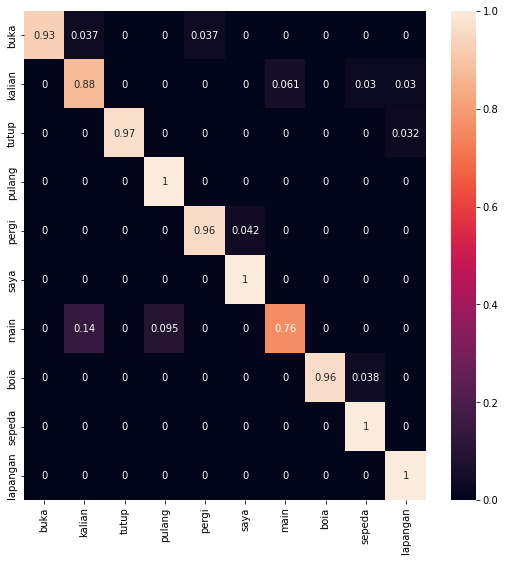

In [ ]:
# make prediction for confusion_matrix
# import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(X_test, batch_size=16)
words=["buka","kalian","tutup","pulang","pergi","saya","main","boia","sepeda","lapangan"]
# predicted word from the test set
y_predi = np.argmax(predict,1)
predicted_word = []
for i in range(0,X_test.shape[0]):
    emo = words[y_predi[i]]
    predicted_word.append(emo)

# get actual word
actual_word = []

y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = words[y_true[i]]
    actual_word.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_word, predicted_word)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ["buka","kalian","tutup","pulang","pergi","saya","main","boia","sepeda","lapangan"]
columns = ["buka","kalian","tutup","pulang","pergi","saya","main","boia","sepeda","lapangan"]
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(9, 9))
sns.heatmap(cm_df, annot=True)
plt.savefig('speech_librosa_hfs2.svg')
print("UAR: ", cm.trace()/cm.shape[0])